In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from scipy import interp
from IPython.display import Image
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import seaborn as sns
from imblearn.over_sampling import SMOTE

%matplotlib inline 

### Load in data for modeling

In [1]:
from importlib import reload
import FE
reload(FE)
from FE import FE
from FE import plotROCCurve

In [12]:
xcols = ['admins', 'employees','contractdays', 'usecompetitors','callcycle', 'associateddeals','timescontacted', 'sessions', 'FF', 'strategic']

#xcols = ['usecompetitors', 'callcycle','sessions', 'FF', 'strategic']

ycol = "churn"

df = pd.read_csv('data.csv')

X, y, xcolnames = FE(df,xcols,ycol)

In [13]:
xcols_lr = ['usecompetitors', 'callcycle','sessions', 'FF', 'strategic']

ycol_lr = "churn"

X_lr, y_lr, xcolnames_lr = FE(df,xcols,ycol)

### Stratified Cross Validation - Since the Response values are not balanced

In [14]:
def stratified_cv(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    stratified_k_fold = StratifiedKFold(n_splits=n_folds, shuffle=shuffle)
    y_pred = y.copy()
    # ii -> train
    # jj -> test indices
    for ii, jj in stratified_k_fold.split(X,y): 
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[jj] = clf.predict(X_test)
    return y_pred

In [15]:
import warnings
warnings.filterwarnings('ignore')

print('Gradient Boosting Classifier:  {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))))

print('Support vector machine(SVM):   {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, svm.SVC))))

print('Random Forest Classifier:      {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, ensemble.RandomForestClassifier))))

print('K Nearest Neighbor Classifier: {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, neighbors.KNeighborsClassifier))))

print('Logistic Regression:           {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, linear_model.LogisticRegression))))

print('XGBoost:           {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, XGBClassifier))))

Gradient Boosting Classifier:  0.85
Support vector machine(SVM):   0.82
Random Forest Classifier:      0.86
K Nearest Neighbor Classifier: 0.83
Logistic Regression:           0.84
XGBoost:           0.87


### Confusion Matrices

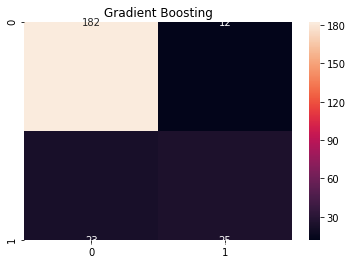

In [8]:
grad_ens_conf_matrix      = metrics.confusion_matrix(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))
sns.heatmap(grad_ens_conf_matrix, annot=True,  fmt='');
title = 'Gradient Boosting'
plt.title(title);

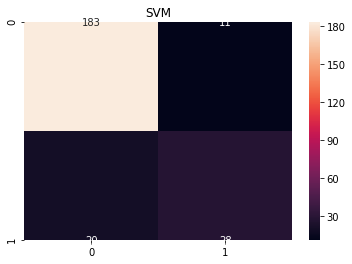

In [9]:
svm_svc_conf_matrix       = metrics.confusion_matrix(y, stratified_cv(X, y, svm.SVC))
sns.heatmap(svm_svc_conf_matrix, annot=True,  fmt='');
title = 'SVM'
plt.title(title);

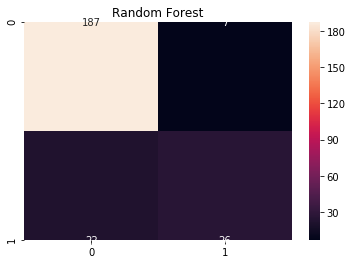

In [10]:
random_forest_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, ensemble.RandomForestClassifier))
sns.heatmap(random_forest_conf_matrix, annot=True,  fmt='');
title = 'Random Forest'
plt.title(title);

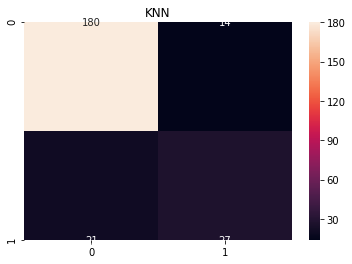

In [11]:
k_neighbors_conf_matrix   = metrics.confusion_matrix(y, stratified_cv(X, y, neighbors.KNeighborsClassifier))
sns.heatmap(k_neighbors_conf_matrix, annot=True,  fmt='');
title = 'KNN'
plt.title(title);

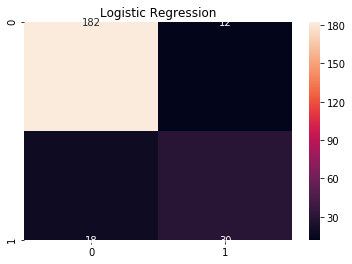

In [12]:
logistic_reg_conf_matrix  = metrics.confusion_matrix(y, stratified_cv(X, y, linear_model.LogisticRegression))
sns.heatmap(logistic_reg_conf_matrix, annot=True,  fmt='');
title = 'Logistic Regression'
plt.title(title);

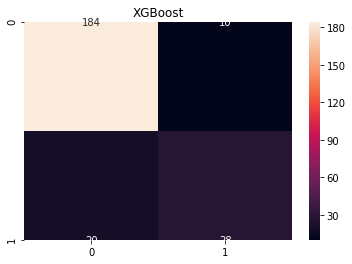

In [13]:
xgboost_reg_conf_matrix  = metrics.confusion_matrix(y, stratified_cv(X, y, XGBClassifier))
sns.heatmap(xgboost_reg_conf_matrix, annot=True,  fmt='');
title = 'XGBoost'
plt.title(title);

### Classification Reports

In [16]:
print('Gradient Boosting Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))))

print('Support vector machine(SVM):\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, svm.SVC))))

print('Random Forest Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, ensemble.RandomForestClassifier))))

print('K Nearest Neighbor Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, neighbors.KNeighborsClassifier))))

print('Logistic Regression:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, linear_model.LogisticRegression))))

print('XGBoost:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, XGBClassifier))))

Gradient Boosting Classifier:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91       194
           1       0.63      0.54      0.58        48

    accuracy                           0.85       242
   macro avg       0.76      0.73      0.75       242
weighted avg       0.84      0.85      0.84       242


Support vector machine(SVM):
               precision    recall  f1-score   support

           0       0.84      0.95      0.90       194
           1       0.61      0.29      0.39        48

    accuracy                           0.82       242
   macro avg       0.73      0.62      0.65       242
weighted avg       0.80      0.82      0.80       242


Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.88      0.97      0.92       194
           1       0.81      0.46      0.59        48

    accuracy                           0.87       242
   macro avg       0.85      0.72     

### AUC Curves

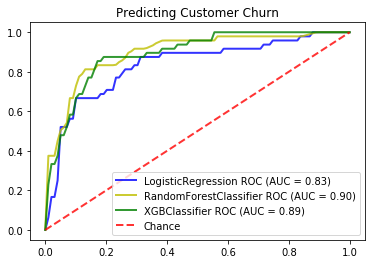

In [17]:
seed = 1234

# Plotting Setup
fig, ax = plt.subplots()

# plotROCCurve(clf_class, X, y, axis, random_state, **kwargs)

# LR ROC Curve Plotting
lr = linear_model.LogisticRegression
plotROCCurve(lr, X=X_lr,y=y_lr,axis=ax,color='b',random_state=seed,C=10, class_weight='balanced', solver='liblinear')

# Random Forest ROC Curve Plotting
rf = ensemble.RandomForestClassifier
plotROCCurve(rf, X,y,ax,'y',seed)

# XGBoost ROC Curve Plotting
xgb = XGBClassifier
plotROCCurve(xgb, X,y,ax,'g',seed)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Predicting Customer Churn")
ax.legend(loc="lower right")
plt.show()

In [18]:
xgbModel = XGBClassifier().fit(X,y)

pd.DataFrame(xgbModel.feature_importances_, index=xcolnames, columns=["Importance"]).sort_values(by="Importance", ascending=False)

,Importance
callcycle_Yearly,0.165555
sessions,0.133276
usecompetitors,0.092311
timescontacted,0.086685
strategic,0.086554
callcycle_Quarterly,0.077771
associateddeals,0.077516
employees,0.071329
contractdays,0.065978
callcycle_Half Year,0.054432
